# Temperature data modelling with Bayesian  regression models

## Theory

I continue the modelling of the global temperature anamoly data but now with Bayesian methods. The Bayesian philosophy interprets probablities in a radically different manner to the frequentist. For a frequentist probabilities represent frequencies of occurence of events, but for a Bayesian probabilities represent degrees of belief about the value of a parameter or a hypothesis. This means that in the Bayesian philosphy data is considered fixed and estimates of parameters respresented by a probability density function that represents the spread in belief about the value of a parameter. 

#### Bayesian parameter estimation

Bayesian inference in a sense is more coherent than frequentist inference because both parameter estimation and model selection are based on one equation, Bayes theorem. Assuming a model $M$ and data $D$ the probability density function describing the degree of belief in the value of the parameter $\theta$ is given by:

\begin{equation}
P(\theta ~|~ D, M) =  \frac{P(D ~|~ \theta, M) P( \theta ~|~ D )}{P(D ~|~ M)}
\end{equation}

Where $P( \theta ~|~ M )$ is our belief about the value of the parameter before we have the data;   $P(D ~|~ M)$ is the model evidience and represents the probablity of the data regardless of the parameter value, i.e. our $\it{a}  \it{priori}$ belief. In parameter estimation it plays the role of a normalization factor but it has a much more fundental role in model selection. $P(\theta ~|~ D, M)$ is our degree of belief in the value of the parameter after the data i.e. our a posteriori belief. Finally $P(D ~|~ \theta, M)$ is the likelihood, which plays a fundamental role in frequentist inference.

#### Bayesian model selection

Assuming a model $M$ and data $D$ the probability of the model is given by:

\begin{equation}
P(M ~|~ D) = P(D ~|~ M) \frac{ P(M)}{P(D)}
\end{equation}

Where $P(M ~|~ D)$ is the a posterior probabilty of model $M$,  $P(D ~|~ M)$ is the model likelihood,  $P(M)$ the a priori probablity of model $M$ and $P(D)$ is the probabilty of the data regardless of the model. We seem to be facing a problem in obtaining these terms but a little thought shows us the way. $P(M)$ is often assumed to be uniform.  The model evidence can rewrite the model likelhihood in a suggestive and useful way:

\begin{equation}
P(D ~|~ M) = \int_{\Omega} P(D ~|~ \theta, M) P(\theta ~|~ M) d\theta
\end{equation}

The first term in the integrand is very familiar, it is the data likelihood! Though the model likelihood has been rewritten in a familiar form computing it from this integral for high dimensional problems can mean a very high computational cost. The $P(D)$ seems impossible to obtain. However, considiering two differing models $ M_1$ and $M_2$ as explanations for our data we can eliminate this term as follows:

\begin{equation}
O_{21} = \frac{P(M_2 ~|~ D)}{P(M_1 ~|~ D) } = \frac{ P(D ~|~ M_2) P(M_2)}{P(D ~|~ M_1) P(M_1)}
\end{equation}

The ratio $O_{21}$ is called the Bayes factor and it is is a measure of the relative strength of both models in explaining the data. In Bayesian model selection it is the Bayes factor that is used in order to carry out model selection. 

# Temperature Data Analysis 

In [305]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

I first load the data into a pandas dataframe and plot it.

In [306]:
csv_data = pd.read_csv("c:/users/jamil/temproj/temp_data.csv")

In [307]:
csv_data = csv_data[::2]
csv_data = csv_data.reset_index()


In [308]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles

In [309]:
annual_temp = csv_data["Average"]
annual_index = list(csv_data["Year"].values)
annual_index = np.arange(len(annual_index))
annual_index_feature = list(csv_data["Year"].values)
prediction_annual_index = [[item] for item in range(min(annual_index_feature),max(annual_index_feature)+10)]

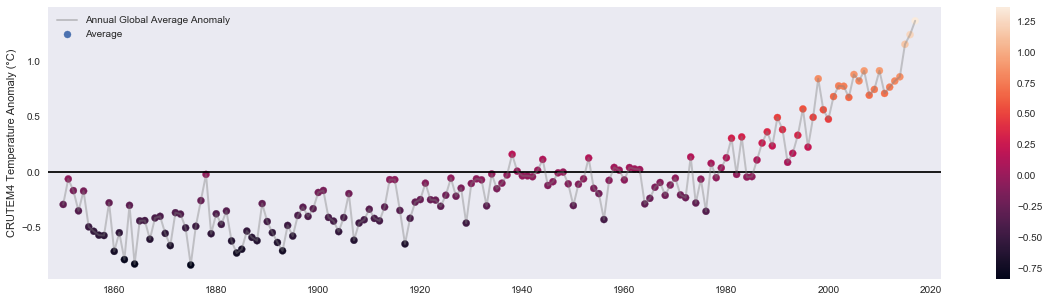

In [310]:
plt.figure(figsize=(20,5))
plt.scatter(csv_data["Year"], csv_data["Average"], marker="o", s=50, c=csv_data["Average"])
plt.plot(csv_data["Year"], csv_data["Average"], label="Annual Global Average Anomaly", alpha=0.4, linewidth=2, c="grey")
plt.hlines(0,min(csv_data["Year"])-3,max(csv_data["Year"])+5)

plt.legend(loc="best")
plt.xlim(min(csv_data["Year"])-3, max(csv_data["Year"])+5)
plt.ylabel(u"CRUTEM4 Temperature Anomaly (\u00B0C)")
plt.colorbar()
plt.grid()
plt.show()

Next the data needs to be put into the right for processing: an array of 3 rows where the first row in the year index, the second is the temperature data and the third is the estimate of the variance.

In [311]:
#data = annual_temp

# year and temp data
x = np.array(annual_index)
y = np.array(annual_temp[:, None])


# estimate the variance
sigma = np.var(csv_data["Average"])
sigma_y = np.ones(len(csv_data['Average']))
sigma_y = sigma*sigma_y[:, None]
x = x[:,None]

# concatenate x, y and sigma_y as rows of the 'data' array
data = np.concatenate((x.T, y.T), axis=0)
data = np.concatenate((data, sigma_y.T), axis=0)


## Bayesian Linear Regression  with Markov Chain Monte Carlo

Define three functions to computer the prior, the likelihood and the log posterior

In [312]:
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

def log_prior(theta):
    # size of theta determines the model.
    # flat prior over a large range
    if np.any(abs(theta) > 100):
        return -np.inf  # log(0)
    else:
        return 200 ** -len(theta)

def log_likelihood(theta, data=data):
    x, y, sigma_y = data
    yM = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2)
                         + (y - yM) ** 2 / sigma_y ** 2)

def log_posterior(theta, data=data):
    theta = np.asarray(theta)
    return log_prior(theta) + log_likelihood(theta, data)

Load the emcee monte carlo package, set some variables and conditions and finally do two MCMC runs, one for a linear model and the other for quadratic model

In [313]:
import emcee

def compute_mcmc(degree, data=data,
                   log_posterior=log_posterior,
                   nwalkers=50, nburn=1000, nsteps=2000):
    ndim = degree + 1  # this determines the model
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
    return trace

trace_2D = compute_mcmc(1)
trace_3D = compute_mcmc(2)


Use the seaborn package to plot the MCMC run as a 2D histogram for the linear model.

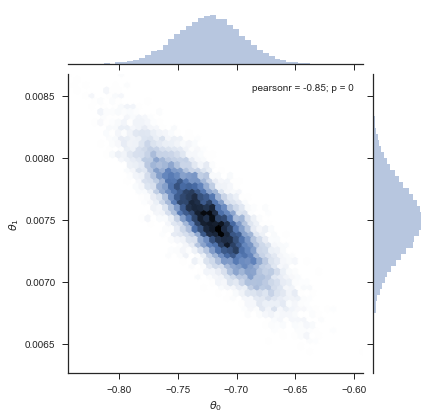

In [315]:
columns = [r'$\theta_{0}$'.format(i) for i in range(3)]
df_2D = pd.DataFrame(trace_2D, columns=columns[:2])

with sns.axes_style('ticks'):
    jointplot = sns.jointplot(r'$\theta_0$', r'$\theta_1$',
                              data=df_2D, kind="hex");
plt.show()

Extract the MCMC simulation data for $theta_0$ and $theta_1$ and plot as histograms.

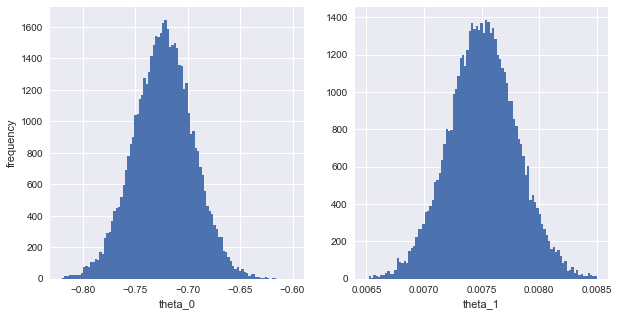

In [316]:
bins1 = np.linspace(-0.82, -0.6, 100)
bins2 = np.linspace(0.0065, 0.0085, 100)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(trace_2D[:,0], bins1)
ax[0].set_ylabel('frequency')
ax[0].set_xlabel('theta_0')
ax[1].hist(trace_2D[:,1], bins2)
ax[1].set_xlabel('theta_1')
plt.show()

I will use the peaks of the posterior distribution as my estimates of the parmameters. This corresponds to the maximum a posterori estimate. Other schemes are possible, such as averages. I obtain smoothed estimates of the pdf of the posterior distributions using the Guassian Kernel density estimate method. The peaks are extracted and places in arrays for later use to plot the linear model obtained.

In [336]:
from scipy import stats

density = stats.gaussian_kde(trace_2D[:,0])

# set the histogram detail level
density.covariance_factor = lambda : .15
density._compute_covariance()

xs0 = np.arange(-0.82, -0.6,.01)
ys0 = density(xs0)
fig, ax = plt.subplots(1,2, figsize = (10,5))

argtheta0 = np.argmax(ys0)

#print(ys1)
np.shape(ys0)
theta0 = xs0[argtheta0]
print(theta0)
ax[0].plot(xs0, ys0, antialiased=True, linewidth=2, color="#A81450")


density = stats.gaussian_kde(trace_2D[:,1])

# set the histogram detail level
density.covariance_factor = lambda : .15
density._compute_covariance()

xs1 = np.arange(0.0065, 0.0085,.0001)
ys1 = density(xs1)

argtheta1 = np.argmax(ys1)

-0.72


Plotting the posterior pdf estimates.

[-0.71999999999999986, 0.0075000000000000023]


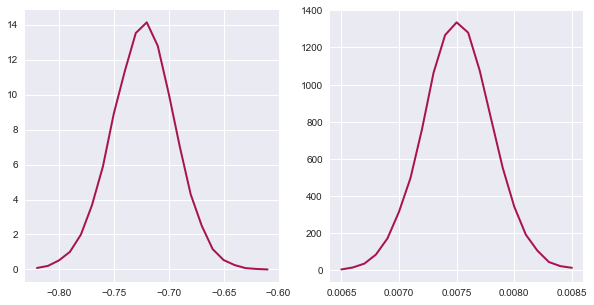

In [337]:
np.shape(ys1)
theta1 = xs1[argtheta1]
thetaLin = [theta0, theta1]
print(thetaLin)
ax[1].plot(xs1, ys1, antialiased=True, linewidth=2, color="#A81450")
plt.show()

I repeat the entire procedure above but now for the quadratic model

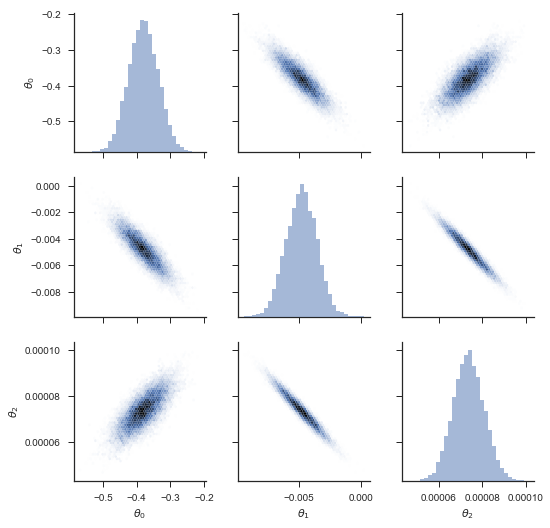

In [338]:
df_3D = pd.DataFrame(trace_3D, columns=columns[:3])

# get the colormap from the joint plot above
cmap = jointplot.ax_joint.collections[0].get_cmap()

with sns.axes_style('ticks'):
    grid = sns.PairGrid(df_3D)
    grid.map_diag(plt.hist, bins=30, alpha=0.5)
    grid.map_offdiag(plt.hexbin, gridsize=50, linewidths=0, cmap=cmap)

plt.show()

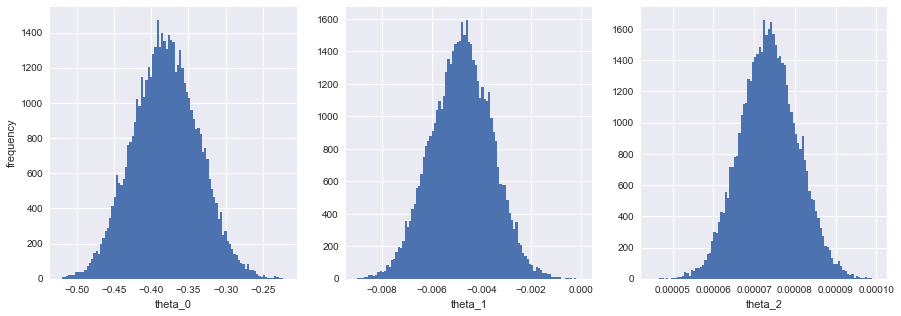

In [339]:
bins1 = np.linspace(-0.52, -0.22, 100)
bins2 = np.linspace(-0.009, 0.0, 100)
bins3 = np.linspace(0.000045, 0.0001, 100)
                    
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(trace_3D[:,0], bins1)
ax[0].set_ylabel('frequency')
ax[0].set_xlabel('theta_0')
ax[1].hist(trace_3D[:,1], bins2)
ax[1].set_xlabel('theta_1')
ax[2].hist(trace_3D[:,2], bins3)
ax[2].set_xlabel('theta_2')
plt.show()

-0.38
-0.0047
[-0.37999999999999989, -0.0047000000000000253, 7.3999999999999928e-05]


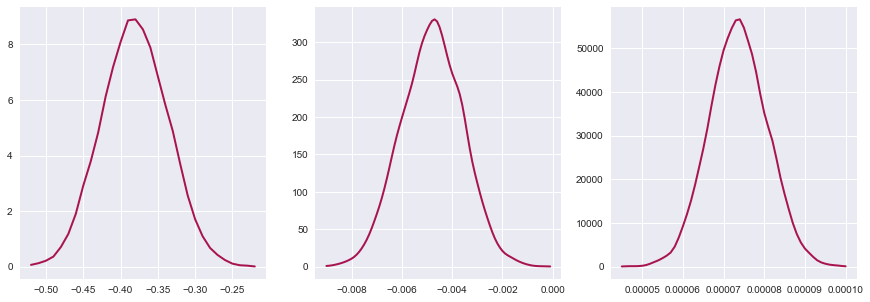

In [340]:
density = stats.gaussian_kde(trace_3D[:,0])

# set the histogram detail level
density.covariance_factor = lambda : .15
density._compute_covariance()

xs0 = np.arange(-0.52, -0.22,.01)
ys0 = density(xs0)
fig, ax = plt.subplots(1,3, figsize = (15,5))

argtheta0 = np.argmax(ys0)

#print(ys1)
np.shape(ys0)
theta0 = xs0[argtheta0]
print(theta0)
ax[0].plot(xs0, ys0, antialiased=True, linewidth=2, color="#A81450")


density = stats.gaussian_kde(trace_3D[:,1])

# set the histogram detail level
density.covariance_factor = lambda : .15
density._compute_covariance()

xs1 = np.arange(-0.009, 0.0,.0001)
ys1 = density(xs1)

argtheta1 = np.argmax(ys1)

#print(ys0)
np.shape(ys1)
theta1 = xs1[argtheta1]
print(theta1)
ax[1].plot(xs1, ys1, antialiased=True, linewidth=2, color="#A81450")



density = stats.gaussian_kde(trace_3D[:,2])

# set the histogram detail level
density.covariance_factor = lambda : .15
density._compute_covariance()

xs2 = np.arange(0.000045, 0.0001,.000001)
ys2 = density(xs2)

argtheta2 = np.argmax(ys2)

#print(ys0)
np.shape(ys2)
theta2 = xs2[argtheta2]
thetaQuad = [theta0, theta1, theta2]
print(thetaQuad)
ax[2].plot(xs2, ys2, antialiased=True, linewidth=2, color="#A81450")
plt.show()


Finally, I plot the curves obtained from the maximim a posteriori estimates of the model parameters

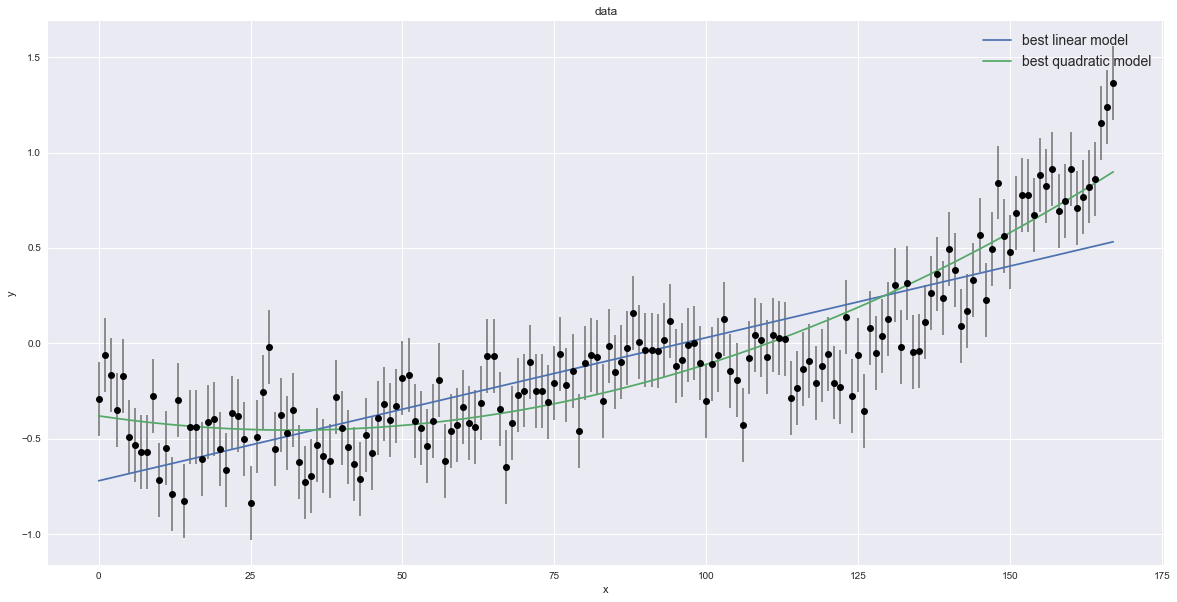

In [341]:
x, y, sigma_y = data
fig, ax = plt.subplots(figsize = (20,10))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(x, polynomial_fit(thetaLin , x), label='best linear model')
ax.plot(x, polynomial_fit(thetaQuad, x), label='best quadratic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');
plt.show()


The linear and quadratic fits are almost the same as those obtained using frequentist methods.

## Bayes factors and model selection 

Which of these model is a better explantion of the data? To decide this question I compute the Bayes factor. For most statistical problems of practical interest this is a computationaly very intense job, however in this case I can use numerical integration methods.

In [342]:
from scipy import integrate

def integrate_posterior_2D(log_posterior, xlim, ylim, data=data):
    func = lambda theta1, theta0: np.exp(log_posterior([theta0, theta1], data))
    return integrate.dblquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1])

def integrate_posterior_3D(log_posterior, xlim, ylim, zlim, data=data):
    func = lambda theta2, theta1, theta0: np.exp(log_posterior([theta0, theta1, theta2], data))
    return integrate.tplquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1],
                             lambda x, y: zlim[0], lambda x, y: zlim[1])


In [343]:
xlim, ylim = zip(trace_2D.min(0), trace_2D.max(0))
%time Z1, err_Z1 = integrate_posterior_2D(log_posterior, xlim, ylim)
print("Z1 =", Z1, "+/-", err_Z1)

Wall time: 37.1 ms
Z1 = 6.02275236704561e-12 +/- 1.947525638678628e-12


In [344]:
xlim, ylim, zlim = zip(trace_3D.min(0), trace_3D.max(0))
%time Z2, err_Z2 = integrate_posterior_3D(log_posterior, xlim, ylim, zlim)
print("Z2 =", Z2, "+/-", err_Z2)

Wall time: 1min 15s
Z2 = 22720819.869407553 +/- 1870.4648236618402


In [345]:
print("Bayes factor:", Z2 / Z1)


Bayes factor: 3.7724977692471496e+18


The Bayes factor is very large indeed, According to the scale of Wass and Raftery a value greater than 150 is considered a very strong evidence for a quadratic model. In Harold Jeffery's scale a value greater than 100 is considered decisive evidence. The enormous number I obtained must therefore be considered virtually conclusive!

# Conclusion

Using Bayesian methods both a linear and a quadratic model were successfully fit the data and Bayesian model selection using Bayes factors gave an almost conclusive decision in favour of a quadratic model to explain the data.

### Comparison of frequentist and Bayesian inference

The results and conclusions of both frequentist and Bayesian analaysis were very close. The optimal linear and quadratic models found by both methods were very similiar and both gave an almost conclusive decision in favour of a quadratic model fit for the data over a linear one. Nevertheless, the frequentist procedure was much time consuming and difficult than the Bayesian. The primary problem was finding the maximum likelihood estimates of the model parameter. Gradient based methods kept on getting stuck suggesting a highly complex likelihood surface. The Bayesian procesdure for parameter estimation, in contrast, was straightforward.

### Future work

Though both the first two projects successfully modelled the temperature anamoly data the modelled used are very restrictive. In particular it is hard for them to indicate a decrease in temperature in recent years. In the final project of the series I use much more flexible machine learning methods to model this dataset in an attempt to answer this question.

# Bibliography

1. Numerical Recipes in C by Press et al. Cambridge Univeristy Press, 1995.
2. Data Analysis: A Bayesian Tuorial by Sivia, Oxford University Press, 2004.
3. Information theory, Inference and Learning Algorithms by MacKay. Cambridge University Press, 2003.